# Introduction

The main objective of this notebook is to create *toy data* to run the LVM sky module. For this we use 1D data generated with the [LVM data simulator](https://github.com/sdss/lvmdatasimulator). In this case, we'll use a DIG simulation with a background of stars labelled as `DIG_bright_linear_full_900`, according to the data simulator naming convention. This simulation was kindly generated and shared by Enrico Congiu for testing purposes.

The following are the steps carried out along this example:

- Get data from **LVM data simulator**:
  * read simulated data in flux units (`*_flux.fits`)
  * read simulated data in electrons (`*_realization.fits`)
  * read simulated data in electrons without noise (`*_no_noise.fits`)
  * calculate flux calibration vector
- Write FITS files with:
  * simulated flux + sky (with noise)
  * simulated flux (without noise)
  * simulated sky (without noise)
  * flux calibration vectors
  
This being said, there are some important limitations of the current implementation, which only objective is to produce that resembles the DRP products up to the point where we enter the sky module.

## Caveats

- The simulations all implement the same sky spectrum across the observed field, there are no sky variations
- In this notebook I don't simulate separated sky and science observations, all sky 'pointings' come from the same simulation
- I implemented a very simplistic LSF and wavelength sampling that not necessarily reflects the final instrument/DRP setup

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import warnings
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)

from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch

from lvmdrp.core.constants import LVM_UNAM_URL
from lvmdrp.utils.examples import fetch_example_data
from lvmdrp.core import rss, image, sky
from lvmdrp.functions import skyMethod
from multiprocessing import Pool, cpu_count

plt.style.use("seaborn-v0_8-talk")

def rss_wave_regrid(in_rss, new_wave=None, new_lsf=None, resample_method="linear", err_sim=500, replace_error=1e10, parallel="auto"):
    """Return a wavelength resampled and LSF-convolved RSS
    
    This function performs a wavelength resampling and spectral resolution degradation to match a
    desired LSF. The input RSS object is assumed to be wavelength calibrated. The units are assumed
    to be anstroms throughout.
    
    Parameters
    ----------
    in_rss : lvmdrp.core.rss.RSS instance
        input RSS wavelength calibrated
    new_wave : array_like, optional
        desired final wavelength sampling. If None, then no resampling is performed
    new_lsf : array_like
        desired final LSF. This is assumed to be worst than the initial `in_rss` resolution. If None, no LSF matching is performed
    resample_method : string, optional
        the method to use in the resampling procedure. Valid options are 'linear' (default) and 'spline'
    err_sim : integer, optional
        number of MC simulations to propagate uncertainties during resampling
    replace_error : float, optional
        value to replace invalid pixels in error array
    parallel : string or int, optional
        whether to run in parallel the resampling and LSF matching. Valid options are 'auto' (default) or integer representing the number of threads to use
    
    Returns
    -------
    out_rss : lvmdrp.core.rss.RSS instance
        new instance of RSS with the new wavelength grid with the desired sampling and LSF
    """
    if new_wave is None and new_lsf is None:
        return in_rss
    
    if parallel=='auto':
        cpus = cpu_count()
    else:
        cpus = int(parallel)
        
    # resample RSS to reference wavelength sampling
    spectra_list = [in_rss[i] for i in range(in_rss._fibers)]
    if new_wave is not None:
        if cpus > 1:
            pool = Pool(cpus)
            threads = []
            for i in range(in_rss._fibers):
                threads.append(pool.apply_async(spectra_list[i].resampleSpec, (new_wave, resample_method, err_sim, replace_error)))

            for i in range(in_rss._fibers):
                spectra_list[i] = threads[i].get()
            pool.close()
            pool.join()
        else:
            for i in range(in_rss._fibers):
                spectra_list[i] = spectra_list[i].resampleSpec(new_wave)
    
    # convolve RSS to reference LSF
    if new_lsf is not None:
        diff_lsf = np.sqrt(new_lsf**2 - in_rss._inst_fwhm[0]**2)
        if cpus > 1:
            pool = Pool(cpus)
            threads = []
            for i in range(in_rss._fibers):
                threads.append(pool.apply_async(spectra_list[i].smoothGaussVariable, (diff_lsf,)))

            for i in range(in_rss._fibers):
                spectra_list[i] = threads[i].get()
            pool.close()
            pool.join()
        else:
            for i in range(in_rss._fibers):
                spectra_list[i] = spectra_list[i].smoothGaussVariable(new_lsf)
    
    # build RSS
    out_rss = rss.RSS.from_spectra1d(spectra_list=spectra_list)
    
    return out_rss

# Download the simulation from UNAM

We have put the simulations at a UNAM-IA server called *mortadelo*, you can access it [here](http://ifs.astroscu.unam.mx/LVM/). There you will find additional data for other examples in this repository.

Here we will be using the **1D simulation** mentioned before. The next piece of code handles the download and storing of the data in the right path.

It is worth to mention that you can easily bypass this downloading procedure by commenting the `fetch_example_data`, storing your custom simulation in the `data_path` and replacing the `SIM_NAME` with the relevant string. Keep in mind that you will need the products from the simulation mentioned in the Introduction section.

In [2]:
# define input data directory
data_path = os.path.abspath(os.path.join("..", "data"))

# let's create the output directory
output_path = "./data"
os.makedirs(output_path, exist_ok=True)

fetch_example_data(url=LVM_UNAM_URL, name="sim_1d", dest_path=data_path)

# define the target simulation
SIM_NAME = "DIG_bright_linear_full_900_{}.fits"
# define cache file for costly RSS convolution
RSS_INS_PATH = os.path.join(output_path, "rss_ins.pkl")
in_path = os.path.join(data_path, "sim_1d", SIM_NAME)
out_path = os.path.join(output_path, SIM_NAME)

[INFO]: example data already exists


# Extract useful data from the simulations

Here we extract relevant metadata and data to build science and sky pointings. Here is a list of what we want to extract:

- First HDU header metadata
- WCS
- Fiber mapping
- Wavelength array
- Flux and error of the science target and the sky in physical units
- Flux and error of the science target and the sky in e-/pix units

In [3]:
# extract primary header
header = fits.getheader(in_path.format("flux"), extname="PRIMARY")
wcs = fits.getheader(in_path.format("flux"), extname="WCS")
# extract fiber map
fibermap_data, fibermap_header = fits.getdata(in_path.format("flux"), extname="FIBERID", header=True)
# extract observed flux with and without sky
wave = fits.getdata(in_path.format("flux"), extname="WAVE")
error_flx = fits.getdata(in_path.format("flux"), extname="ERR")
sci_tot_flx = fits.getdata(in_path.format("flux"), extname="TOTAL")
sci_obj_flx = fits.getdata(in_path.format("flux"), extname="TARGET")
sky_mod_flx = fits.getdata(in_path.format("flux"), extname="SKY")
# extract instrumental flux with and without sky
wave = fits.getdata(in_path.format("realization"), extname="WAVE")
error_cnt = fits.getdata(in_path.format("realization"), extname="ERR")
sci_tot_cnt = fits.getdata(in_path.format("realization"), extname="TOTAL")
sci_obj_cnt = fits.getdata(in_path.format("realization"), extname="TARGET")
sky_mod_cnt = fits.getdata(in_path.format("realization"), extname="SKY")

[WARNING]: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect. (UserWarning)


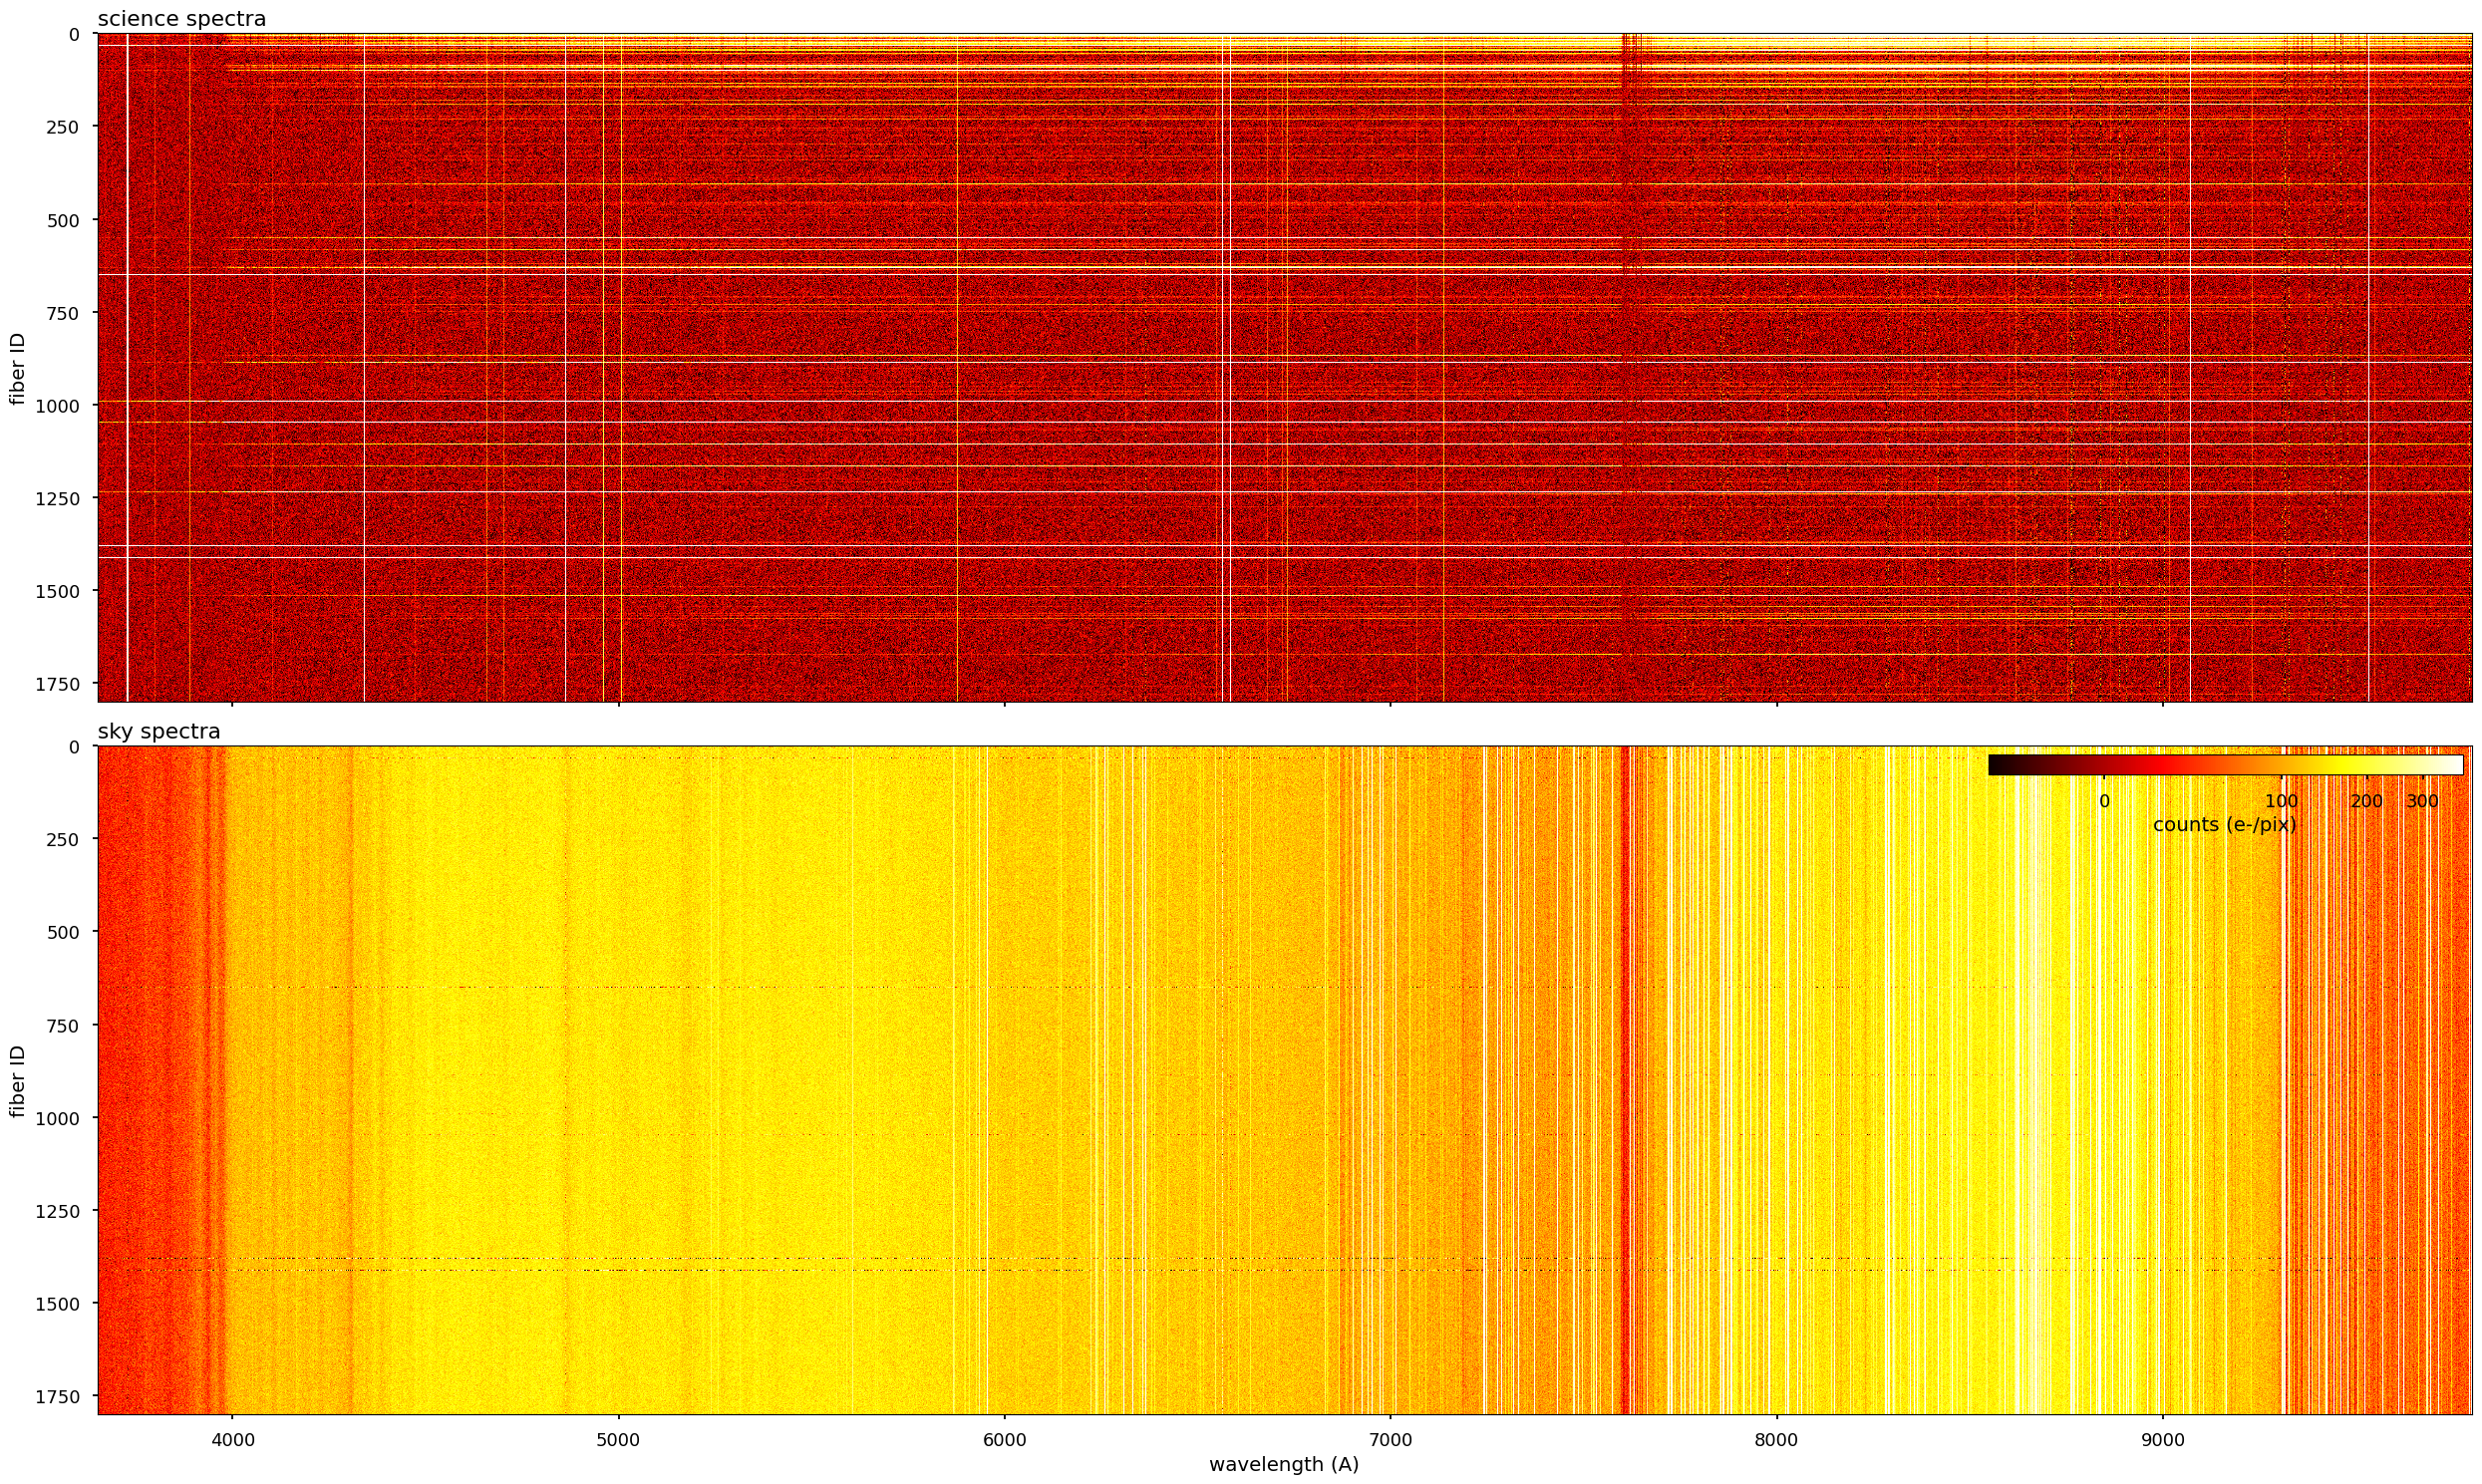

In [4]:
data1 = sci_obj_cnt
data2 = sky_mod_cnt

norm = ImageNormalize(data1, interval=PercentileInterval(95), stretch=AsinhStretch())

xmin, xmax = data1.shape[0], 0
ymin, ymax = wave.min(), wave.max()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25,15), sharex=True, sharey=True)
im1 = ax1.imshow(data1, extent=(ymin,ymax,xmin,xmax), cmap=plt.cm.hot, norm=norm, interpolation="none", aspect="auto")
im2 = ax2.imshow(data2, extent=(ymin,ymax,xmin,xmax), cmap=plt.cm.hot, norm=norm, interpolation="none", aspect="auto")

axins1 = inset_axes(ax2, width="20%", height="3%", loc="upper right")
axins1.xaxis.set_ticks_position("bottom")
cba = fig.colorbar(im2, cax=axins1, orientation="horizontal")

ax1.set_title("science spectra", loc="left")
ax2.set_title("sky spectra", loc="left")
ax1.set_ylabel("fiber ID")
ax2.set_ylabel("fiber ID")
ax2.set_xlabel("wavelength (A)")
cba.set_label("counts (e-/pix)")
fig.tight_layout()

# Mock RSS science and sky data

Next, we want to simulate science and sky pointings. For this, we use the `lvmdrp.core.rss.RSS` class, which has some useful methods for RSS handling.

Note that we are setting the LSF (`inst_fwhm`) as a constant $0.5$ Angstroms throughout the wavelength range, this is by construction the LSF of the 1D data simulations.
Also, the number of sky fibers are set to $59$ for the SkyE and $60$ for the SkyW telescopes.

Most importantly, we are extracting the sky fibers from the same simulation, and those are all the same (as mentioned before).

Finally, we build a mock flux calibration vector from the *collapsed* science RSS in physical and electrons units. Note that the this flux calibration vector is also uniform across the cross-dispersion direction. Also when collapsing the RSS along the cross-dispersion direction using the method `RSS.create1DSpec`, we get a different object from the class `lvmdrp.core.spectrum1d.Spectrum1D`.

In [5]:
# create science RSS
sci_flx_rss = rss.RSS(data=sci_tot_flx, wave=wave, inst_fwhm=np.ones_like(wave)*0.5, error=error_flx)
sci_cnt_rss = rss.RSS(data=sci_tot_cnt, wave=wave, inst_fwhm=np.ones_like(wave)*0.5, error=error_cnt)

# create skies RSSs
NSKY_W, NSKY_E = 59, 60
idx = np.random.choice(np.arange(sci_flx_rss._fibers, dtype=int), NSKY_W+NSKY_E, replace=False)
idx_w, idx_e = idx[:NSKY_W], idx[NSKY_W:]

skyw_flx_rss = rss.RSS(data=sky_mod_flx[idx_w], wave=wave, inst_fwhm=np.ones_like(wave)*0.5)
skyw_cnt_rss = rss.RSS(data=sky_mod_cnt[idx_w], wave=wave, inst_fwhm=np.ones_like(wave)*0.5, error=error_cnt[idx_w])

skye_flx_rss = rss.RSS(data=sky_mod_flx[idx_e], wave=wave, inst_fwhm=np.ones_like(wave)*0.5)
skye_cnt_rss = rss.RSS(data=sky_mod_cnt[idx_e], wave=wave, inst_fwhm=np.ones_like(wave)*0.5, error=error_cnt[idx_e])

# calculate flux calibration vector
flux_cal = skyw_flx_rss.create1DSpec() / skyw_cnt_rss.create1DSpec()

# Convolve with a mildly realistic linear LSF

In order to mimic a more realistic instrumental wavelength sampling and LSF, we assume a resolving power of $4000$ across the wavelength range and a sampling of $\delta\lambda=1.0$ Angstrom.

Note that this resampling and (specially) the convolution across the cross-dispersion direction is computationaly demanding, despite it is parallelized (`parallel=4`) and will take on all the threads available. Depending on your machine this operation will still take several minutes. The good news is that the results will be cached in a pickle, so you have to run this only once.

In [6]:
# define new wavelength
dif_wav = 1.0
new_wav = np.arange(wave[0], wave[-1]+dif_wav, dif_wav)
# define differential resolution
res = 4000
new_lsf = new_wav / res
dif_lsf = np.sqrt(new_lsf**2 - 0.5**2)

# downgrade in resolution and resample
if not os.path.isfile(RSS_INS_PATH):
    sci_ins_rss = rss_wave_regrid(sci_cnt_rss, new_wave=new_wav, new_lsf=new_lsf, err_sim=10, parallel=4)
    skyw_ins_rss = rss_wave_regrid(skyw_cnt_rss, new_wave=new_wav, new_lsf=new_lsf, err_sim=10, parallel=4)
    skye_ins_rss = rss_wave_regrid(skye_cnt_rss, new_wave=new_wav, new_lsf=new_lsf, err_sim=10, parallel=4)

    pickle.dump((sci_ins_rss, skyw_ins_rss, skye_ins_rss), open(RSS_INS_PATH, "wb"))
else:
    sci_ins_rss, skyw_ins_rss, skye_ins_rss = pickle.load(open(RSS_INS_PATH, "rb"))

# Add some random noise to the data

Because the downsampling and smoothing of the previous step probably hampered the initial noise in the data, we will compensate this effect by adding random noise to the data using a Gaussian distribution with variance `*._error`. We do this for all three simulated RSS objects corresponding to science and sky *pointings*.

In [7]:
# add noise to resampled spectra to compensate the smoothing effect
noise_sci = np.random.randn(*sci_ins_rss._error.shape) * sci_ins_rss._error
noise_skyw = np.random.randn(*skyw_ins_rss._error.shape) * skyw_ins_rss._error
noise_skye = np.random.randn(*skye_ins_rss._error.shape) * skye_ins_rss._error

sci_ins_rss._data = sci_ins_rss._data + noise_sci
skyw_ins_rss._data = skyw_ins_rss._data + noise_skyw
skye_ins_rss._data = skye_ins_rss._data + noise_skye

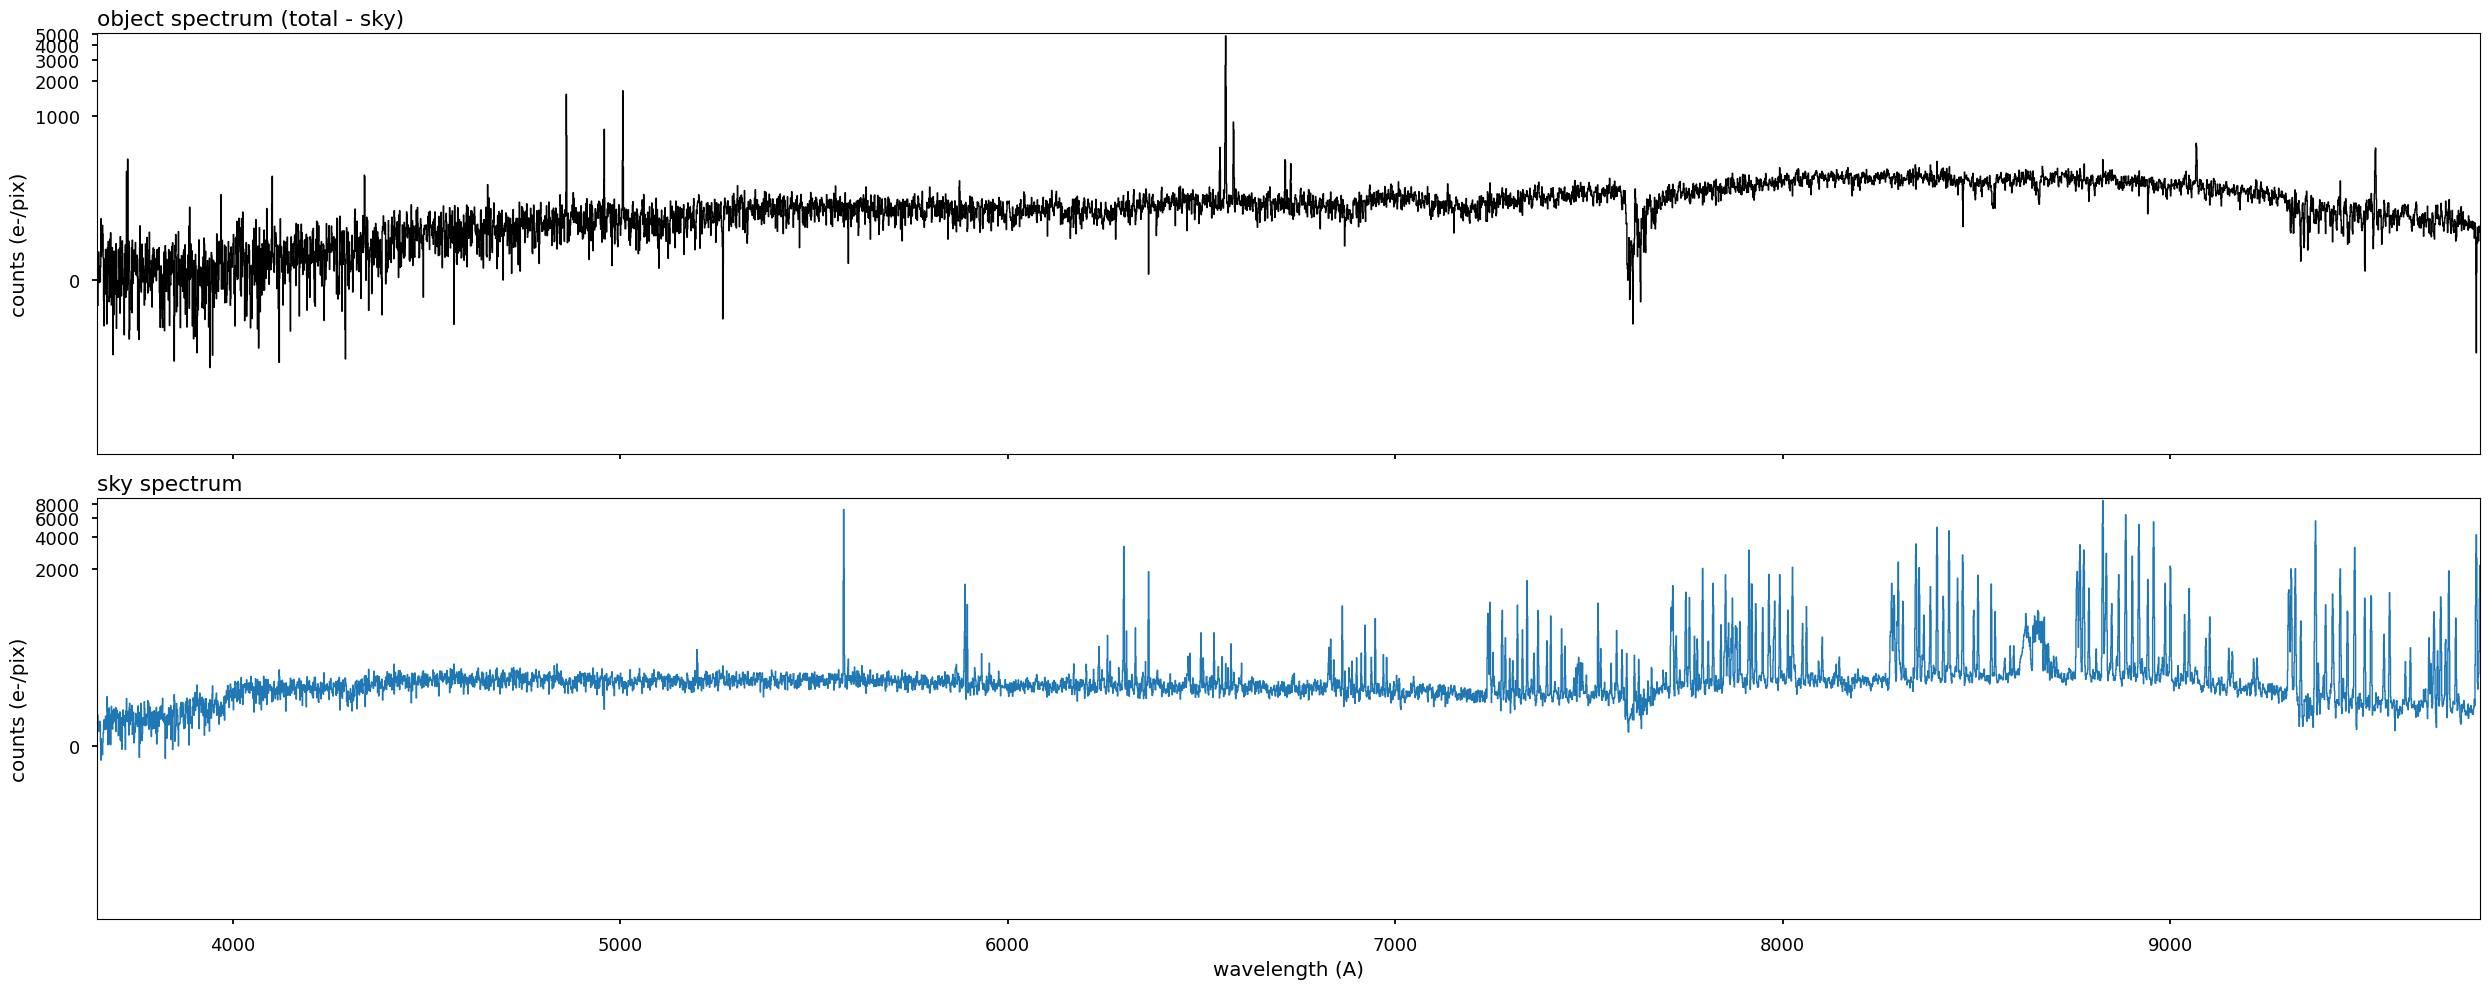

In [8]:
i_fiber = 30

sci_spec = sci_ins_rss[i_fiber]
sky_spec = skyw_ins_rss[i_fiber]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25,10), sharex=True, sharey=False)
ax1.step(sci_spec._wave, sci_spec._data - sky_spec._data, lw=1, color="k")
ax2.step(sky_spec._wave, sky_spec._data, lw=1, color="tab:blue")
ax1.set_xlim(wave.min(), wave.max())
ax1.set_title("object spectrum (total - sky)", loc="left")
ax2.set_title("sky spectrum", loc="left")
ax1.set_ylabel("counts (e-/pix)")
ax2.set_ylabel("counts (e-/pix)")
ax2.set_xlabel("wavelength (A)")
ax1.set_yscale("function", functions=(norm,norm.inverse))
ax2.set_yscale("function", functions=(norm,norm.inverse))
fig.tight_layout()

# Store the data in disk

In order to run the sky module, we need to store the simulated data in the right format. Remember that the entry point of the sky module occurs right after combining all three channels in to one RSS.

Here we will store the science and the sky pointings in the corresponding format, taking care of the relevant header information. We also store the fiber maps of all three pointings in separated binary tables and the flux calibration vector also in a FITS file.

In [9]:
# write flux calibration vector
flux_cal.writeFitsData(out_path.format("fluxcal"))
# write fiber map tables
fits.BinTableHDU(data=fibermap_data, header=fibermap_header).writeto(out_path.format("sci_fibmap"), overwrite=True)
fits.BinTableHDU(data=fibermap_data[idx_w], header=fibermap_header).writeto(out_path.format("skyw_fibmap"), overwrite=True)
fits.BinTableHDU(data=fibermap_data[idx_e], header=fibermap_header).writeto(out_path.format("skye_fibmap"), overwrite=True)
# set header
del header["EXT?"]
sci_ins_rss.setHeader(header=header)
skyw_ins_rss.setHeader(header=header)
skye_ins_rss.setHeader(header=header)
# set uniform wavelength
sci_ins_rss.setWave(sci_ins_rss._wave)
skyw_ins_rss.setWave(skyw_ins_rss._wave)
skye_ins_rss.setWave(skye_ins_rss._wave)
sci_ins_rss.setInstFWHM(sci_ins_rss._inst_fwhm)
skyw_ins_rss.setInstFWHM(skyw_ins_rss._inst_fwhm)
skye_ins_rss.setInstFWHM(skye_ins_rss._inst_fwhm)
# write simulated science and skies
sci_ins_rss.writeFitsData(out_path.format("sci"))
skyw_ins_rss.writeFitsData(out_path.format("skyw"))
skye_ins_rss.writeFitsData(out_path.format("skye"))